In [1]:
import pandas as pd
import numpy as np
import nltk


In [2]:
from gensim.models import Word2Vec

In [3]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# Ensure nltk dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Funcția de preprocesare
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

In [8]:
# Aplică preprocesarea pe coloanele de interes
train['processed_text'] = train['text'].apply(preprocess_text)
train['processed_title'] = train['title'].apply(preprocess_text)

val['processed_text'] = val['text'].apply(preprocess_text)
val['processed_title'] = val['title'].apply(preprocess_text)

test['processed_text'] = test['text'].apply(preprocess_text)
test['processed_title'] = test['title'].apply(preprocess_text)


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combină textul și titlul
train['combined_text'] = train['processed_title'] + " " + train['processed_text']
val['combined_text'] = val['processed_title'] + " " + val['processed_text']
test['combined_text'] = test['processed_title'] + " " + test['processed_text']

In [10]:
# Pregătirea datelor pentru model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

# Transformă textele în secvențe
X_train = tokenizer.texts_to_sequences(train['combined_text'])
X_val = tokenizer.texts_to_sequences(val['combined_text'])
X_test = tokenizer.texts_to_sequences(test['combined_text'])

In [11]:
# Aplică padding
max_length = 100
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding='post')

# Pregătire etichete
y_train = train['label']
y_val = val['label']
y_test = test['label']

In [12]:
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Antrenează un model Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

In [13]:
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [14]:
# Define the CNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),  # Embedding layer
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # 1D Convolutional layer
    MaxPooling1D(pool_size=2),                              # Max pooling layer
    Dropout(0.5),                                           # Dropout layer for regularization
    Conv1D(filters=64, kernel_size=3, activation='relu'),   # Additional convolutional layer
    MaxPooling1D(pool_size=2),                              # Max pooling layer
    Dropout(0.5),
    Flatten(),                                              # Flatten to feed into dense layers
    Dense(128, activation='relu'),                          # Fully connected layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')                          # Output layer (binary classification)
])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


In [17]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Load the best model
from tensorflow.keras.models import load_model
best_cnn_model = load_model('best_cnn_model.h5')

# Evaluate the model
y_pred = (best_cnn_model.predict(X_test_pad) > 0.5).astype('int32')
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5953 - loss: 0.8501
Epoch 1: val_accuracy improved from -inf to 0.80532, saving model to best_cnn_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5959 - loss: 0.8487 - val_accuracy: 0.8053 - val_loss: 0.4409
Epoch 2/20
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7982 - loss: 0.4273
Epoch 2: val_accuracy improved from 0.80532 to 0.81531, saving model to best_cnn_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7983 - loss: 0.4271 - val_accuracy: 0.8153 - val_loss: 0.4204
Epoch 3/20
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8270 - loss: 0.3992
Epoch 3: val_accuracy improved from 0.81531 to 0.82529, saving model to best_cnn_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8270 - loss: 0.3989 - val_accuracy: 0.8253 - val_loss: 0.3833
Epoch 4/20
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8412 - loss: 0.3618
Epoch 4: val_accuracy improved from 0.82529 to 0.83028, saving model to best_cnn_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8412 - loss: 0.3622 - val_accuracy: 0.8303 - val_loss: 0.4061
Epoch 5/20
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8488 - loss: 0.3532
Epoch 5: val_accuracy did not improve from 0.83028
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8486 - loss: 0.3536 - val_accuracy: 0.8053 - val_loss: 0.4065
Epoch 6/20
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8511 - loss: 0.3372
Epoch 6: val_accuracy did not improve from 0.83028
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8511 - loss: 0.3373 - val_accuracy: 0.8253 - val_loss: 0.3706
Epoch 7/20
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8593 - loss: 0.3073
Epoch 7: val_accuracy did not improve from 0.83028
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8591 - loss: 0.3079 - val_accuracy: 0.8253 - val_loss: 0.3543


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.8369384359400999
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       320
           1       0.81      0.86      0.83       281

    accuracy                           0.84       601
   macro avg       0.84      0.84      0.84       601
weighted avg       0.84      0.84      0.84       601



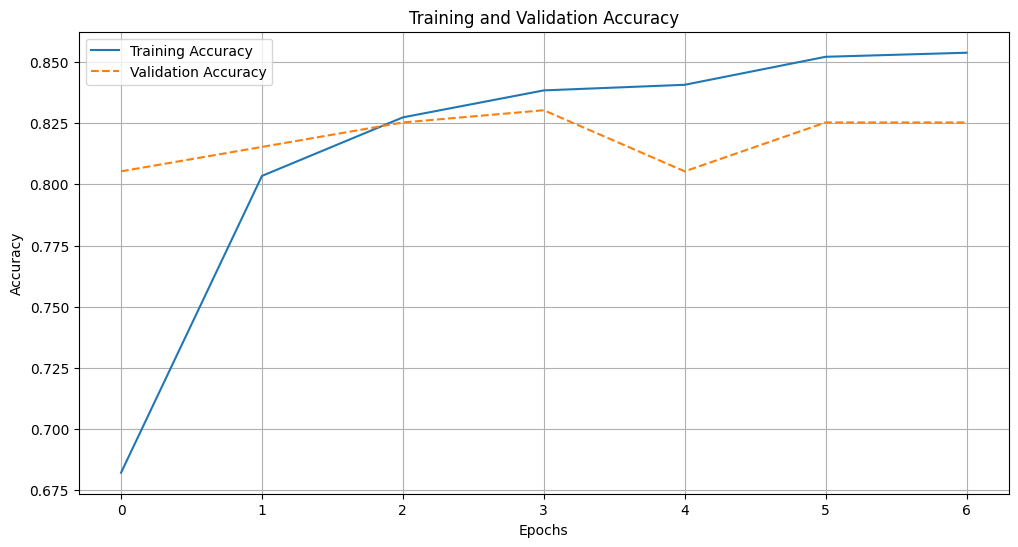

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

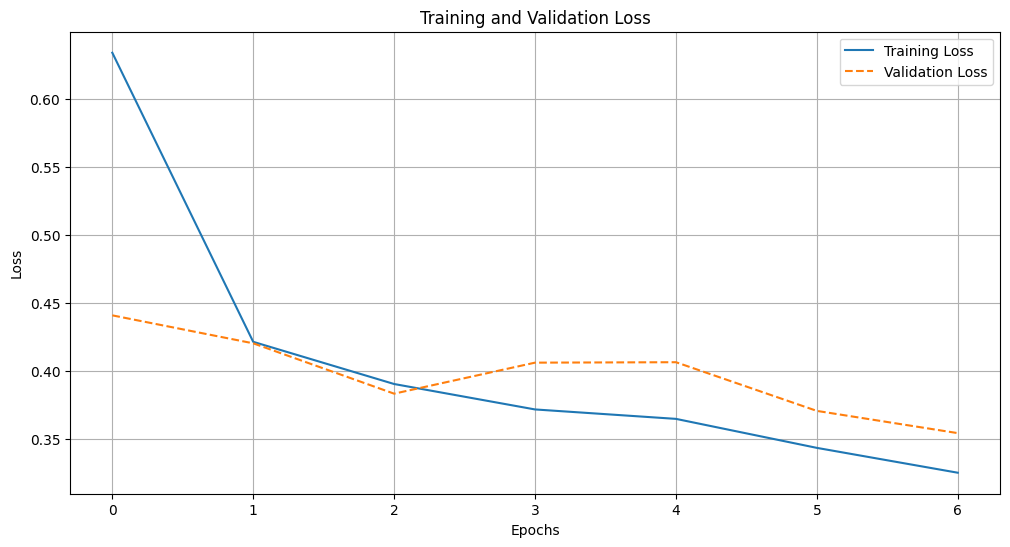

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

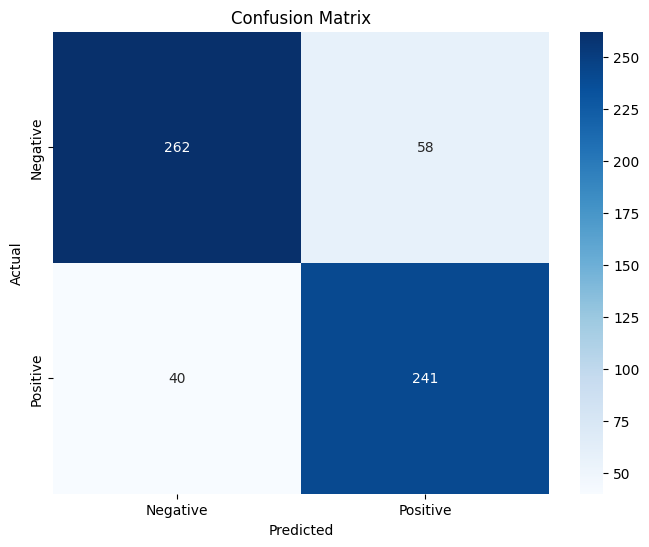

In [20]:
# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

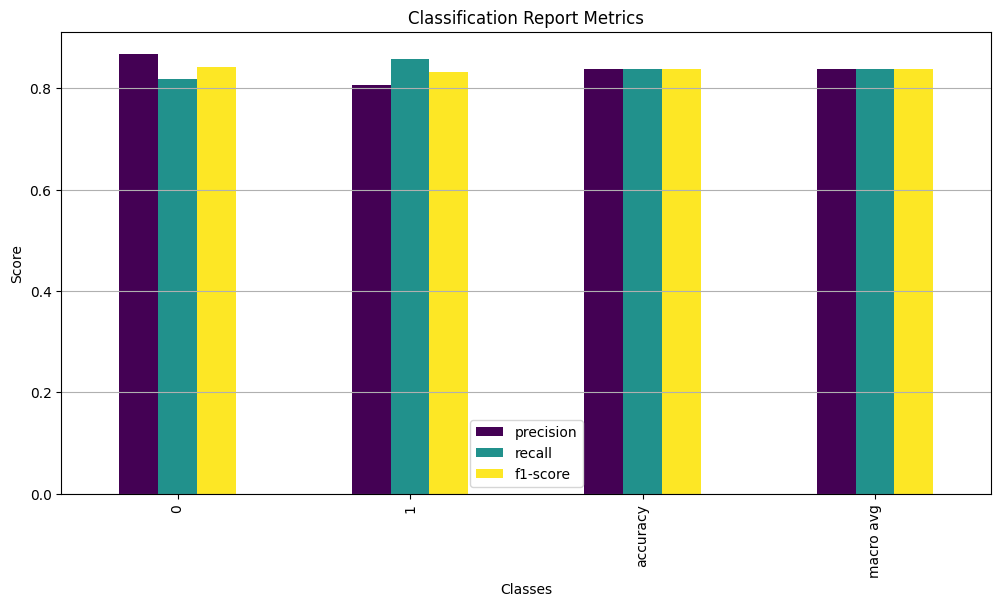

In [21]:
# 4. Classification Report Visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-1, :]  # Exclude support row

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.grid(axis='y')
plt.show()

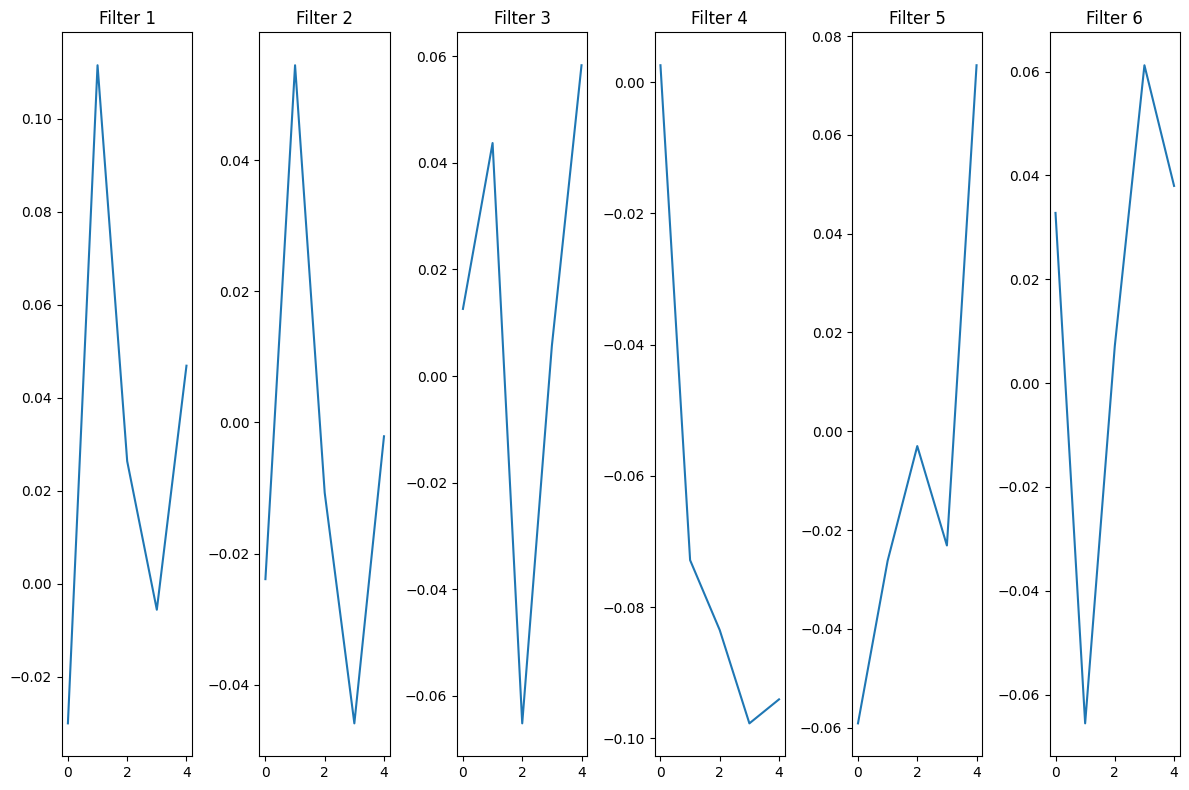

In [22]:
# Extract weights from the first Conv1D layer
conv1_weights = model.layers[1].get_weights()[0]

# Visualize a few filters
num_filters = 6  # Number of filters to visualize
plt.figure(figsize=(12, 8))
for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.plot(conv1_weights[:, 0, i])
    plt.title(f'Filter {i + 1}')
plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


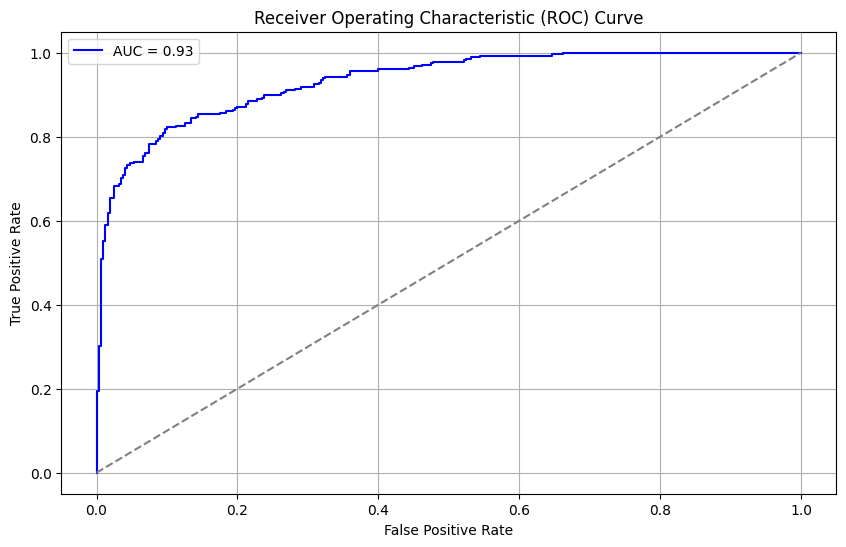

In [23]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
y_pred_prob = best_cnn_model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


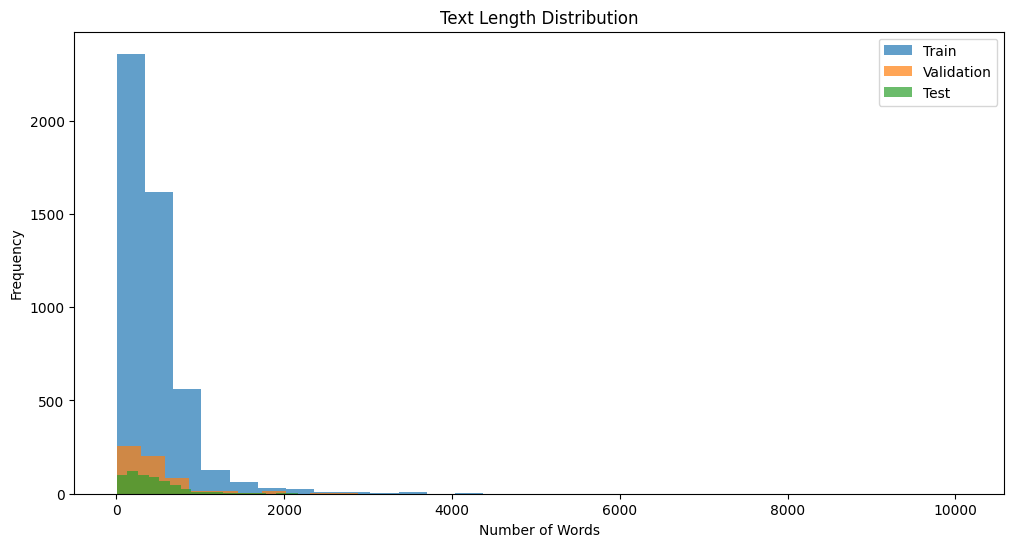

In [29]:
# Compute text lengths
train_lengths = train['combined_text'].apply(lambda x: len(x.split()))
val_lengths = val['combined_text'].apply(lambda x: len(x.split()))
test_lengths = test['combined_text'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=30, alpha=0.7, label='Train')
plt.hist(val_lengths, bins=30, alpha=0.7, label='Validation')
plt.hist(test_lengths, bins=30, alpha=0.7, label='Test')
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()
